In [76]:
import matplotlib.pylab as plot
import numpy as np
from astropy.io import fits,ascii
from astropy.table import Table

In [31]:
# Read GBM catalog
dir=''#'/Users/jracusin/GBM/'
gbm=fits.open(dir+'gbmgrbcat.fits')
gbm=gbm[1].data

In [104]:
# define spectral models
def pl(eng,alpha,epiv=100):
    f=(eng/epiv)**alpha
    return f

def comp(eng,alpha,epeak,epiv=100):
    f=(eng/epiv)**alpha*np.exp(-eng*(2.+alpha)/epeak)
    return f

def bbody(eng,kt):
    f=8.0525*eng**2/(kt**4*(np.exp(eng/kt)-1))
    return f

def band(eng,alpha,epeak,beta,enorm=100):
  w1=np.where(eng <= (alpha-beta)*epeak/(2+alpha))
  w2=np.where(eng >= (alpha-beta)*epeak/(2+alpha))
  f=np.zeros(len(eng))
  if len(w1[0]) > 0:
      f[w1]=(eng[w1]/enorm)**alpha*np.exp(-(2+alpha)*eng[w1]/epeak)
  if len(w2[0]) > 0:
      f[w2]=((alpha-beta)*epeak/enorm/(2+alpha))**(alpha-beta)*np.exp(beta-alpha)*(eng[w2]/enorm)**beta
  return f

In [62]:
# only grab short GRBs
s=np.where(gbm['T90']<=2.)[0]
sgrbs=gbm[s]
print sgrbs.columns

ColDefs(
    name = 'NAME'; format = 'A12'; start = 1
    name = 'RA'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 14
    name = 'DEC'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 23
    name = 'TRIGGER_TIME'; format = 'F15.0'; unit = 'MJD'; disp = 'F15.7'; start = 32
    name = 'T90'; format = 'F8.0'; unit = 'S'; disp = 'F8.3'; start = 48
    name = 'T90_ERROR'; format = 'F9.0'; unit = 'S'; disp = 'F9.3'; start = 57
    name = 'T90_START'; format = 'F9.0'; unit = 'S'; disp = 'F9.3'; start = 67
    name = 'FLUENCE'; format = 'F10.0'; unit = 'ERG/CM^2'; disp = 'E10.4'; start = 77
    name = 'FLUENCE_ERROR'; format = 'F13.0'; unit = 'ERG/CM^2'; disp = 'E13.4'; start = 88
    name = 'FLUX_1024'; format = 'F9.0'; unit = 'PHOTON/CM^2/S'; disp = 'F9.4'; start = 102
    name = 'FLUX_1024_ERROR'; format = 'F15.0'; unit = 'PHOTON/CM^2/S'; disp = 'F15.4'; start = 112
    name = 'FLUX_1024_TIME'; format = 'F14.0'; unit = 'S'; disp = 'F14.3'; start = 128
    name = 'FLUX_

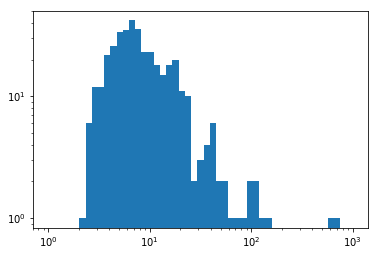

In [72]:
## plot 64 ms peak flux
plot.figure()
plot.hist(sgrbs['FLUX_64'],bins=np.logspace(0,3,50))
plot.xscale('log')
plot.yscale('log')
plot.show()

In [73]:
## grab 10%, 50%, 90% sGRBs
nsgrbs=len(sgrbs)
so=np.argsort(sgrbs['FLUX_64'])
low=so[np.round(nsgrbs*0.1).astype('int')]
mid=so[np.round(nsgrbs*0.5).astype('int')]
high=so[np.round(nsgrbs*0.9).astype('int')]

In [81]:
## sanity checks & retrieve best fit models
print sgrbs['PFLX_PLAW_PHTFLUX'][low],sgrbs['PFLX_PLAW_PHTFLUX'][mid],sgrbs['PFLX_PLAW_PHTFLUX'][high]
print sgrbs['PFLX_SPECTRUM_START'][low],sgrbs['PFLX_SPECTRUM_START'][mid],sgrbs['PFLX_SPECTRUM_START'][high]
print sgrbs['PFLX_SPECTRUM_STOP'][low],sgrbs['PFLX_SPECTRUM_STOP'][mid],sgrbs['PFLX_SPECTRUM_STOP'][high]
print sgrbs['PFLX_SPECTRUM_STOP'][low]-sgrbs['PFLX_SPECTRUM_START'][low],sgrbs['PFLX_SPECTRUM_STOP'][mid]-sgrbs['PFLX_SPECTRUM_START'][mid],sgrbs['PFLX_SPECTRUM_STOP'][high]-sgrbs['PFLX_SPECTRUM_START'][high]
print sgrbs['PFLX_BEST_FITTING_MODEL'][low],sgrbs['PFLX_BEST_FITTING_MODEL'][mid],sgrbs['PFLX_BEST_FITTING_MODEL'][high]

3.028861 9.336103 20.96718
-0.192 -0.064 0.576
-0.128 0.0 0.64
0.064 0.064 0.06400000000000006
PFLX_PLAW PFLX_PLAW PFLX_COMP


In [102]:
print sgrbs['PFLX_PLAW_AMPL'][low],sgrbs['PFLX_PLAW_INDEX'][low]

0.006484706 -1.127856


In [99]:
## grab spectrum, and check that integrated spectrum is equal to photon flux from catalog
eng=np.logspace(1,3,15)
#eng=np.linspace(10,1000,10)
flow=sgrbs['PFLX_PLAW_AMPL'][low]*pl(eng,sgrbs['PFLX_PLAW_INDEX'][low])
fmid=sgrbs['PFLX_PLAW_AMPL'][mid]*pl(eng,sgrbs['PFLX_PLAW_INDEX'][mid])
fhigh=sgrbs['PFLX_COMP_AMPL'][high]*comp(eng,sgrbs['PFLX_COMP_INDEX'][high],sgrbs['PFLX_COMP_EPEAK'][high])
print np.trapz(flow,eng),np.trapz(fmid,eng),np.trapz(fhigh,eng)

3.095602247131911 9.641658195647626 21.26613387835024


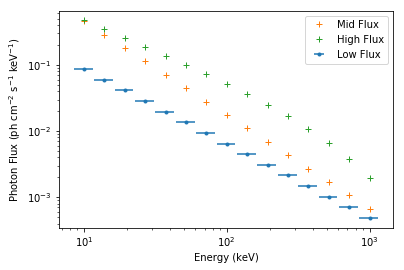

In [103]:
## plot spectra
plot.figure()
plot.errorbar(eng,flow,xerr=0.15*eng,label='Low Flux',marker='.',linestyle='None')
plot.plot(eng,fmid,label='Mid Flux',marker='+',linestyle='None')
plot.plot(eng,fhigh,label='High Flux',marker='+',linestyle='None')
plot.xscale('log')
plot.yscale('log')
plot.xlabel('Energy (keV)')
plot.ylabel(r'Photon Flux (ph cm$^{-2}$ s$^{-1}$ keV$^{-1}$)')
plot.legend()
plot.show()

In [80]:
## write out files
data = Table([eng, flow], names=['energy', 'flux'])
ascii.write(data,dir+'low_sGRB_spectrum.dat',overwrite=True)
## write out files
data = Table([eng, fmid], names=['energy', 'flux'])
ascii.write(data,dir+'mid_sGRB_spectrum.dat',overwrite=True)
## write out files
data = Table([eng, fhigh], names=['energy', 'flux'])
ascii.write(data,dir+'high_sGRB_spectrum.dat',overwrite=True)

In [ ]:
## 170817
fcomp=comp(eng,-0.62,182)